In [33]:
# Extracting zipfile by using ZipFile method

In [2]:
from zipfile import ZipFile

with ZipFile('dogs-vs-cats.zip','r') as zipobj:
    zipobj.extractall()

with ZipFile('train.zip','r') as zipobj:
    zipobj.extractall()

with ZipFile('test1.zip','r') as zipobj:
    zipobj.extractall()

In [3]:
import os

In [4]:
#create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/','test/']
for subdir in subdirs:
    #create label subdiretories
    labeldirs = ['dogs/','cats/']
    for labldir in labeldirs:
        newdir = dataset_home+subdir+labldir
        os.makedirs(newdir,exist_ok = True)

In [5]:
from os import makedirs
from os import listdir
from shutil import copyfile
#create directories
from random import seed,random
seed(1)
#define ratio of pictures to use for validation 
val_ratio = .25
#copy training dataset images into subdirectories
src_directory ='train'
dataset_home='dataset_dogs_vs_cats/'
for file in listdir(src_directory):
    src=src_directory+'/'+file
    dst_dir='train/'
    if random() < val_ratio:
        dst_dir='test/'
    if file.startswith('cat'):
        dst=dataset_home + dst_dir +'cats/' + file
        copyfile(src,dst)
    elif file.startswith('dog'):
        dst=dataset_home + dst_dir +'dogs/' + file
        copyfile(src,dst)
        



## Prepare a model for transfer learning 

In [6]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
model = VGG16(include_top =False, input_shape = (224,224,3))
# mark loaded lalyers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1=Dense(128,activation = 'relu',kernel_initializer = 'he_uniform')(flat1)
output = Dense(1,activation = "sigmoid")(class1)
# define new model
model = Model(inputs = model.inputs,outputs = output)
#compile model
opt = SGD (learning_rate =0.001,momentum = 0.9)
model.compile(optimizer =opt, loss = 'binary_crossentropy',metrics =['accuracy'])

Include_top =False means, before flatten all are accepted.rest we will use our model to train. and we set this layers are not trainable by running the loop

flat1 = Flatten()(model.layers[-1].output)     this line means i am flattening last layer of the model and
store it to the variable named flat1

Here we use sigmoid because we have binary classification problem. Here we are using SGD with momentum 

In [12]:
datagen = ImageDataGenerator(featurewise_center =True)
#specify imagenet mean values for centering
datagen.mean =[123.68,116.779,103.939]
#prepare iterator
train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',class_mode='binary',batch_size=32,target_size=(224,224))
test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',class_mode='binary',batch_size=32,target_size=(224,224))
#fit model
history = model.fit(train_it,steps_per_epoch = len(train_it),validation_data = test_it,validation_steps =len(test_it),epochs=3,verbose=1)

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/3
585/585 [==============================] - 143s 231ms/step - loss: 0.1764 - accuracy: 0.9661 - val_loss: 0.0721 - val_accuracy: 0.9778
Epoch 2/3
585/585 [==============================] - 132s 226ms/step - loss: 0.0247 - accuracy: 0.9913 - val_loss: 0.0725 - val_accuracy: 0.9776
Epoch 3/3
585/585 [==============================] - 132s 226ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0980 - val_accuracy: 0.9784


so basically imagegenerator is used to feed the datas into RAM separately not directly. because in our case data has too much size so we can not load datas 
at once. because ram can not support it, our system may hanged. so imagegenenrator are basically make an iterator and takes some images and feed to the ram after completing this will again transfer another images to the ram

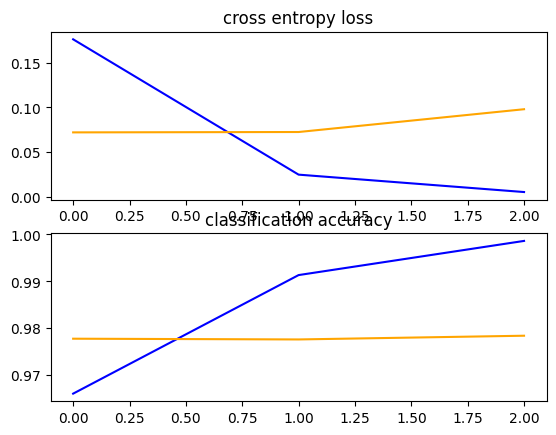

In [13]:
import matplotlib.pyplot as plt
import sys
plt.subplot(211)
plt.title('cross entropy loss')
plt.plot(history.history['loss'],color='blue',label ='train')
plt.plot(history.history['val_loss'],color='orange',label ='test')
#plot accuracy
plt.subplot(212)
plt.title('classification accuracy')
plt.plot(history.history['accuracy'],color='blue',label ='train')
plt.plot(history.history['val_accuracy'],color='orange',label ='test')
#save plot to file
filename = sys.argv[0].split('/')[-1]
plt.savefig(filename + '_plot.png')


In [34]:
# Let's save our model

In [14]:
model.save('transfer_learning(cat&dog).h5')

In [35]:
# Testing our model for one image

In [38]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Loading the model
model = load_model('transfer_learning(cat&dog).h5')

# Loading and preparing the image
img_path = 'D:\cat.111.jpg'
img = load_img(img_path, target_size=(224, 224))
img = img_to_array(img)  # converting image to numpy array
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # reshaping image to be suitable for our model

model.predict(img)

1/1 [==============================] - 0s 119ms/step


array([[0.]], dtype=float32)

In [39]:
import cv2

In [40]:
import matplotlib.pyplot as plt 

In [41]:
testimg = cv2.imread(r'D:\cat.111.jpg')

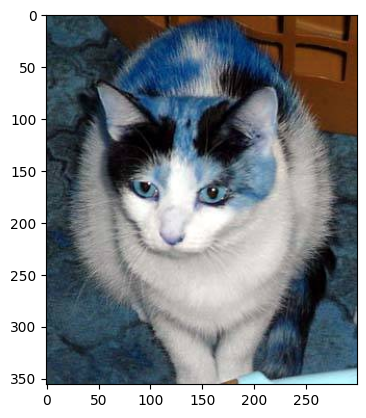

In [42]:
plt.imshow(testimg)

In [43]:
testimg.shape

(356, 299, 3)

In [44]:
test_img = cv2.resize(testimg,(224,224))

In [45]:
test_input = test_img.reshape((1,224,224,3))

In [46]:
model.predict(test_input)

1/1 [==============================] - 0s 165ms/step


array([[0.]], dtype=float32)

In [47]:
# Testing our model for multiple images

In [48]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Loading the model
model = load_model('transfer_learning(cat&dog).h5')

# Directory containing the images
dir_path = r'D:\images'

# Get list of all the images
img_paths = [os.path.join(dir_path, img) for img in os.listdir(dir_path) if img.endswith(".jpg")]

# Loop over the images
for img_path in img_paths:
    # Load and prepare the image
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)  # converting image to numpy array
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # reshaping images for our model

    # Predicting the class of the image
    prediction = model.predict(img)
    
    # Printing the prediction
    if prediction[0][0] > 0.5:
        print(f'The image {img_path} is a dog.')
    else:
        print(f'The image {img_path} is a cat.')



1/1 [==============================] - 0s 108ms/step
The image D:\images\1.jpg is a dog.
1/1 [==============================] - 0s 16ms/step
The image D:\images\10.jpg is a cat.
1/1 [==============================] - 0s 19ms/step
The image D:\images\11.jpg is a cat.
1/1 [==============================] - 0s 24ms/step
The image D:\images\12.jpg is a dog.
1/1 [==============================] - 0s 21ms/step
The image D:\images\13.jpg is a cat.
1/1 [==============================] - 0s 18ms/step
The image D:\images\14.jpg is a cat.
1/1 [==============================] - 0s 27ms/step
The image D:\images\15.jpg is a cat.
1/1 [==============================] - 0s 16ms/step
The image D:\images\16.jpg is a cat.
1/1 [==============================] - 0s 19ms/step
The image D:\images\17.jpg is a dog.
1/1 [==============================] - 0s 24ms/step
The image D:\images\18.jpg is a dog.
1/1 [==============================] - 0s 19ms/step
The image D:\images\19.jpg is a cat.
1/1 [================